In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/Project4

/content/drive/MyDrive/Colab Notebooks/Project4


In [3]:
import os, tqdm, random, torch
import numpy as np
import torch.nn as nn
from PIL import Image
from multiprocessing import Manager as SharedMemoryManager
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt
from torchvision.models.resnet import ResNet, BasicBlock
from typing import Optional, Union, Iterable, Tuple

In [4]:
# Config Parameters
data_dir = './alpaca'
epochs = 5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_channels = 3
first_fmap_channels = 64
last_fmap_channels = 512 #2048
output_channels = 3
time_embedding = 256
learning_rate = 1e-4 #1e-2
min_lr = 1e-6
weight_decay = 0.0
n_timesteps = 300
beta_min = 1e-4
beta_max = 2e-2
beta_scheduler = 'linear'
batch_size = 10
n_samples = 4
cache_size = 1000
image_size = (256, 256)

number of images: 333


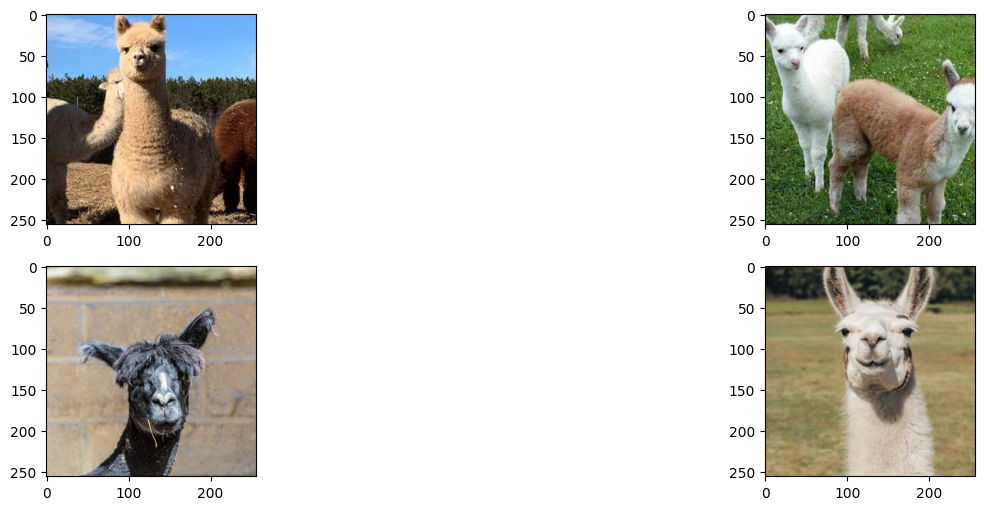

In [5]:
#load samples
files = os.listdir(data_dir)

print(f'number of images: {len(files)}')

n_rows, n_cols = 2, 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(17, 6))

for i in range(n_rows):
    for j in range(n_cols):
        idx = random.randint(0, len(files)-1)

        img = Image.open(os.path.join(data_dir, f'{files[idx]}'))

        axs[i, j].imshow(img)

In [6]:
class ImageDataset(Dataset):
    def __init__(self, img_dir:str, image_size:tuple, n_samples:int=4000, cache_size:int=1000):
        self.img_dir = img_dir
        self.n_samples = n_samples
        self.image_size = image_size
        self.cache_size = cache_size

        self.files = os.listdir(self.img_dir)
        self.files = random.sample(self.files, self.n_samples)

        r"""
        container for caching samples:
        structure
        ----------------------
        {idx:<image>}
        """
        self.cache = SharedMemoryManager().dict()

        self.transforms = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.ToTensor(),

        ])


    def __len__(self):
        return len(self.files)


    def _addToCache(self, idx:int, image:torch.Tensor):
        if self.cache_size > 0:
            if len(self.cache) >= self.cache_size:
                keys = list(self.cache.keys())
                key_to_remove = random.choice(keys)
                self.cache.pop(key_to_remove)
            self.cache[idx] = image


    def __getitem__(self, idx:int):
        if idx in self.cache.keys():return self.cache[idx]

        file_path = os.path.join(self.img_dir, self.files[idx])
        image = Image.open(file_path).convert('RGB')

        if self.transforms:
            #apply transforms
            image = self.transforms(image)
        print(image[0])
        self._addToCache(idx, image)

        return image

In [7]:
class DiffusionUtils:
    def __init__(self, n_timesteps:int, beta_min:float, beta_max:float, device:str='cpu', scheduler:str='linear'):
        assert scheduler in ['linear', 'cosine'], 'scheduler must be linear or cosine'

        self.n_timesteps = n_timesteps
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.device = device
        self.scheduler = scheduler

        self.betas = self.betaSamples()
        self.alphas = 1 - self.betas
        self.alpha_hat = torch.cumprod(self.alphas, dim=0)


    def betaSamples(self):
        if self.scheduler == 'linear':
            return torch.linspace(start=self.beta_min, end=self.beta_max, steps=self.n_timesteps).to(self.device)

        elif self.scheduler == 'cosine':
            betas = []
            for i in reversed(range(self.n_timesteps)):
                T = self.n_timesteps - 1
                beta = self.beta_min + 0.5*(self.beta_max - self.beta_min) * (1 + np.cos((i/T) * np.pi))
                betas.append(beta)

            return torch.Tensor(betas).to(self.device)


    def sampleTimestep(self, size:int):
        #the size argument will let you randomly sample a batch of timesteps
        #output shape: (N, )
        return torch.randint(low=1, high=self.n_timesteps, size=(size, )).to(self.device)


    def noiseImage(self, x:torch.Tensor, t:torch.LongTensor):
        #expected input is a batch of inputs.
        #image shape: (N, C, H, W)
        #t:torch.Tensor shape: (N, )
        assert len(x.shape) == 4, 'input must be 4 dimensions'
        alpha_hat_sqrts = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        one_mins_alpha_hat_sqrt = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        noise = torch.randn_like(x).to(self.device)
        return (alpha_hat_sqrts * x) + (one_mins_alpha_hat_sqrt * noise), noise


    def sample(self, x:torch.Tensor, model:nn.Module):
        #x shape: (N, C, H, W)
        assert len(x.shape) == 4, 'input must be 4 dimensions'
        model.eval()

        with torch.no_grad():
            iterations = range(1, self.n_timesteps)
            for i in tqdm.tqdm(reversed(iterations)):
                #batch of timesteps t
                t = (torch.ones(x.shape[0]) * i).long().to(self.device)

                #params
                alpha = self.alphas[t][:, None, None, None]
                beta = self.betas[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                one_minus_alpha = 1 - alpha
                one_minus_alpha_hat = 1 - alpha_hat

                #predict noise pertaining for a given timestep
                predicted_noise = model(x, t)

                if i > 1:noise = torch.randn_like(x).to(self.device)
                else:noise = torch.zeros_like(x).to(self.device)

                x = 1/torch.sqrt(alpha) * (x - ((one_minus_alpha / torch.sqrt(one_minus_alpha_hat)) * predicted_noise))
                x = x + (torch.sqrt(beta) * noise)

            return x

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import imageio

In [9]:
class Hourglass(nn.Module):
    def __init__(self):
        super(Hourglass, self).__init__()

        self.leaky_relu = nn.LeakyReLU()

        self.d_conv_1 = nn.Conv2d(2, 8, 5, stride=2, padding=2)
        self.d_bn_1 = nn.BatchNorm2d(8)

        self.d_conv_2 = nn.Conv2d(8, 16, 5, stride=2, padding=2)
        self.d_bn_2 = nn.BatchNorm2d(16)

        self.d_conv_3 = nn.Conv2d(16, 32, 5, stride=2, padding=2)
        self.d_bn_3 = nn.BatchNorm2d(32)
        self.s_conv_3 = nn.Conv2d(32, 4, 5, stride=1, padding=2)

        self.d_conv_4 = nn.Conv2d(32, 64, 5, stride=2, padding=2)
        self.d_bn_4 = nn.BatchNorm2d(64)
        self.s_conv_4 = nn.Conv2d(64, 4, 5, stride=1, padding=2)

        self.d_conv_5 = nn.Conv2d(64, 128, 5, stride=2, padding=2)
        self.d_bn_5 = nn.BatchNorm2d(128)
        self.s_conv_5 = nn.Conv2d(128, 4, 5, stride=1, padding=2)

        self.d_conv_6 = nn.Conv2d(128, 256, 5, stride=2, padding=2)
        self.d_bn_6 = nn.BatchNorm2d(256)

        self.u_deconv_5 = nn.ConvTranspose2d(256, 124, 4, stride=2, padding=1)
        self.u_bn_5 = nn.BatchNorm2d(128)

        self.u_deconv_4 = nn.ConvTranspose2d(128, 60, 4, stride=2, padding=1)
        self.u_bn_4 = nn.BatchNorm2d(64)

        self.u_deconv_3 = nn.ConvTranspose2d(64, 28, 4, stride=2, padding=1)
        self.u_bn_3 = nn.BatchNorm2d(32)

        self.u_deconv_2 = nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1)
        self.u_bn_2 = nn.BatchNorm2d(16)

        self.u_deconv_1 = nn.ConvTranspose2d(16, 8, 4, stride=2, padding=1)
        self.u_bn_1 = nn.BatchNorm2d(8)

        self.out_deconv = nn.ConvTranspose2d(8, 3, 4, stride=2, padding=1)
        self.out_bn = nn.BatchNorm2d(3)

    def forward(self, noise):
        down_1 = self.d_conv_1(noise)
        down_1 = self.d_bn_1(down_1)
        down_1 = self.leaky_relu(down_1)

        down_2 = self.d_conv_2(down_1)
        down_2 = self.d_bn_2(down_2)
        down_2 = self.leaky_relu(down_2)

        down_3 = self.d_conv_3(down_2)
        down_3 = self.d_bn_3(down_3)
        down_3 = self.leaky_relu(down_3)
        skip_3 = self.s_conv_3(down_3)

        down_4 = self.d_conv_4(down_3)
        down_4 = self.d_bn_4(down_4)
        down_4 = self.leaky_relu(down_4)
        skip_4 = self.s_conv_4(down_4)

        down_5 = self.d_conv_5(down_4)
        down_5 = self.d_bn_5(down_5)
        down_5 = self.leaky_relu(down_5)
        skip_5 = self.s_conv_5(down_5)

        down_6 = self.d_conv_6(down_5)
        down_6 = self.d_bn_6(down_6)
        down_6 = self.leaky_relu(down_6)

        up_5 = self.u_deconv_5(down_6)
        up_5 = torch.cat([up_5, skip_5], 1)
        up_5 = self.u_bn_5(up_5)
        up_5 = self.leaky_relu(up_5)

        up_4 = self.u_deconv_4(up_5)
        up_4 = torch.cat([up_4, skip_4], 1)
        up_4 = self.u_bn_4(up_4)
        up_4 = self.leaky_relu(up_4)

        up_3 = self.u_deconv_3(up_4)
        up_3 = torch.cat([up_3, skip_3], 1)
        up_3 = self.u_bn_3(up_3)
        up_3 = self.leaky_relu(up_3)

        up_2 = self.u_deconv_2(up_3)
        up_2 = self.u_bn_2(up_2)
        up_2 = self.leaky_relu(up_2)

        up_1 = self.u_deconv_1(up_2)
        up_1 = self.u_bn_1(up_1)
        up_1 = self.leaky_relu(up_1)

        out = self.out_deconv(up_1)
        out = self.out_bn(out)
        out = nn.Sigmoid()(out)

        return out

tensor([[0.2039, 0.1412, 0.1373,  ..., 0.3176, 0.3255, 0.3373],
        [0.1961, 0.1647, 0.1686,  ..., 0.3216, 0.3333, 0.3569],
        [0.1922, 0.1882, 0.2000,  ..., 0.3647, 0.3765, 0.4078],
        ...,
        [0.4275, 0.4667, 0.4667,  ..., 0.6824, 0.6941, 0.6549],
        [0.4745, 0.4706, 0.4902,  ..., 0.7098, 0.6706, 0.6078],
        [0.5098, 0.4784, 0.5059,  ..., 0.7137, 0.6000, 0.4980]])


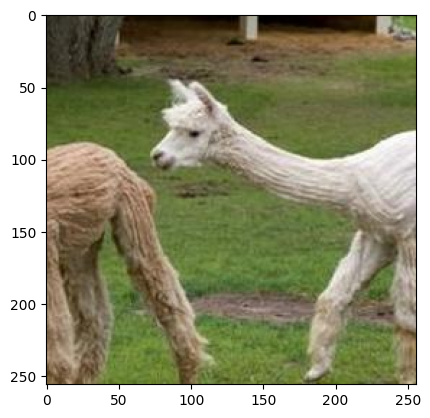

In [36]:
dataset = ImageDataset(data_dir, image_size, n_samples)
sample_img = dataset[0]
plt.imshow(sample_img.permute(1, 2, 0))

linear beta scheduling...


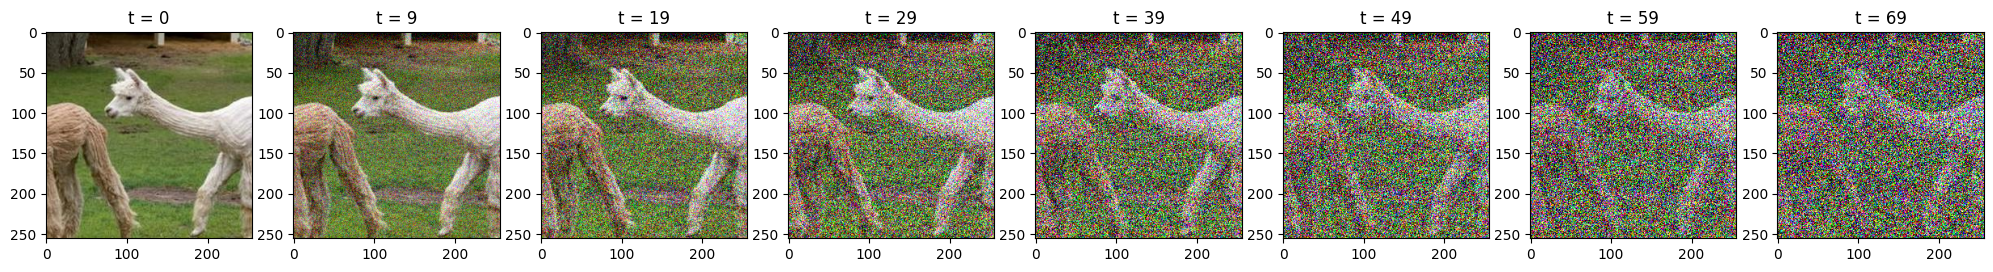

5

In [37]:
n_steps = 10
T = n_steps*7

alpha_values = {}
noisy_image = []
for scheduler in ['linear']:
    print(f'{scheduler} beta scheduling...')

    diffusion = DiffusionUtils(T, beta_min, beta_max, scheduler=scheduler)
    alpha_values[scheduler] = diffusion.alphas

    fig, axs = plt.subplots(1, (T//n_steps)+1, figsize=(25, 15))

    axs[0].imshow(sample_img.permute(1, 2, 0))
    axs[0].set_title('t = 0')

    for idx, t in enumerate(range(n_steps-1, T, n_steps)):
        t = torch.Tensor([t]).long()
        x, _ = diffusion.noiseImage(sample_img.unsqueeze(0), t)
        noisy_image.append(x)
        #print(x.shape)
        axs[idx+1].imshow(x.squeeze(0).permute(1, 2, 0))
        axs[idx+1].set_title(f't = {t.item()}')
    plt.show()
    print('\n')
noisy_image = noisy_image[0:5]
noisy_image.reverse()
len(noisy_image)


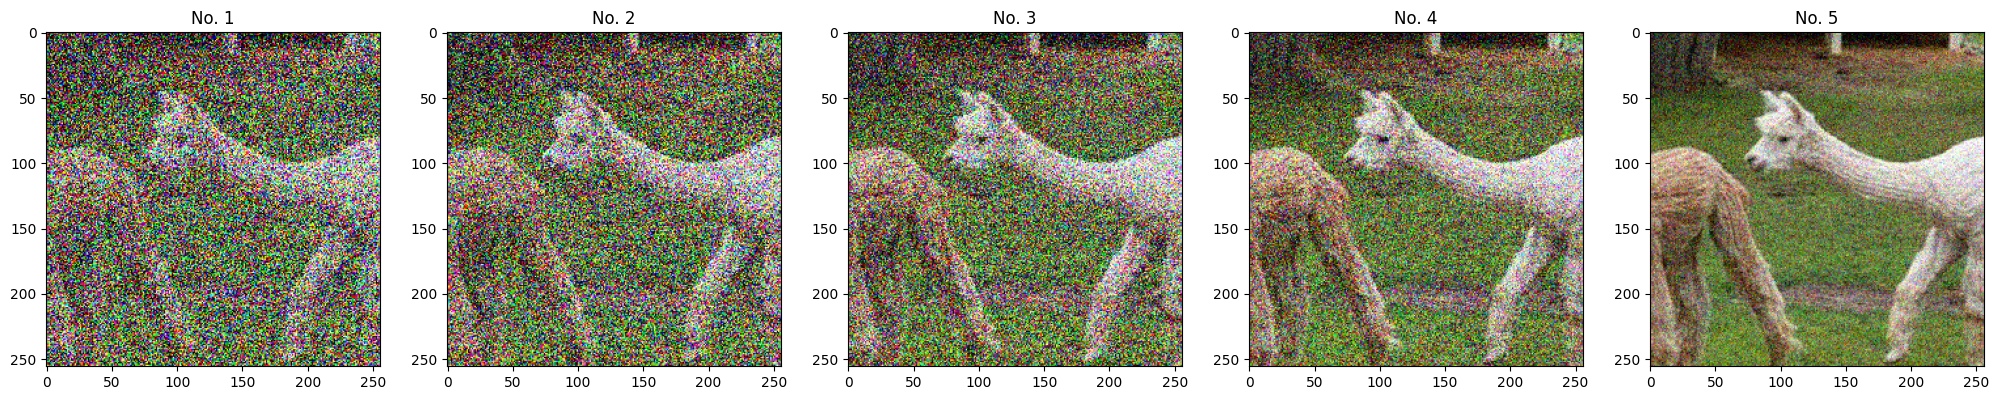

In [38]:
fig, axs = plt.subplots(1, len(noisy_image), figsize=(25, 15))
for i in range(len(noisy_image)):

  axs[i].imshow(noisy_image[i].squeeze(0).permute(1, 2, 0))
  axs[i].set_title(f'No. {i+1}')
plt.show()
print('\n')

In [39]:
!pip install scikit-image


In [40]:
import torch
import torch.nn.functional as F

def calculate_psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    if mse == 0:
        return float('inf')
    max_pixel_value = 1.0
    psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))
    return psnr.item()
from skimage.metrics import structural_similarity as ssim
def calculate_ssim(img1, img2):
    img1 = img1.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    img2 = img2.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    ssim_value = ssim(img1, img2, multichannel=True)
    return ssim_value

In [41]:
lr = 0.0085
device = 'cpu'
mse = nn.MSELoss()

<ipython-input-40-d4757617557e>:5: UserWarning: Using a target size (torch.Size([1, 3, 256, 256])) that is different to the input size (torch.Size([3, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(img1, img2)
<ipython-input-40-d4757617557e>:15: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(img1, img2, multichannel=True)


Iteration: 84 Loss: 0.3112509
Iteration: 131 Loss: 0.2067192
Iteration: 169 Loss: 0.1219483
Iteration: 219 Loss: 0.0558110
Iteration: 282 Loss: 0.0151539


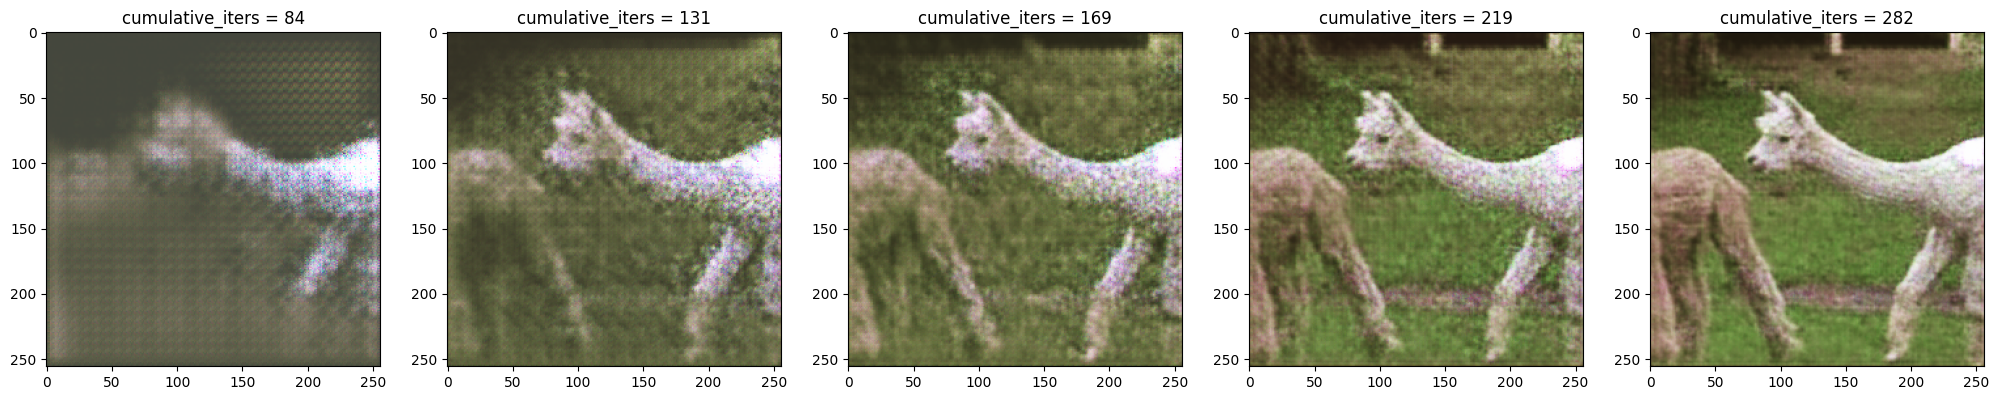

In [42]:
hg_net = Hourglass()
hg_net.to(device)
optimizer = optim.Adam(hg_net.parameters(), lr=lr)
iter=400
iters = []
n_iter = iter
to_tensor = tv.transforms.ToTensor()
z = torch.Tensor(np.mgrid[:256, :256]).unsqueeze(0).to(device) / 256
fig, axs = plt.subplots(1, len(noisy_image), figsize=(25, 15))
#alpha_values = {}
#diffusion = DiffusionUtils(n_iter, beta_min, beta_max, scheduler=scheduler)
#alpha_values[scheduler] = diffusion.alphas
withnoise_psnr_values = []
withnoise_ssim_values = []
withnoise_losses = []
prev_psnr = 0
dec_count = 0
cul_iter=0
for t in range(len(noisy_image)):
    temp_y = hg_net(z)
    n_iter = iter
    for i in range(n_iter):
        optimizer.zero_grad()

        y = hg_net(z)
        loss = mse(noisy_image[t], y)
        psnr_value = calculate_psnr(sample_img, y)
        withnoise_psnr_values.append(psnr_value)
        ssim_value = calculate_ssim(sample_img, y)
        withnoise_ssim_values.append(ssim_value)
        withnoise_losses.append(loss.item())
        if psnr_value > prev_psnr:
          prev_psnr = psnr_value
        else:
          dec_count += 1
          if dec_count==10:
            n_iter = i+1
            temp_y = y
            prev_psnr = 0
            dec_count=0
            break

        loss.backward()
        optimizer.step()
    iters.append(n_iter)
    temp_y = temp_y[0].cpu().detach().permute(1,2,0)*255
    temp_y = np.array(temp_y, np.uint8)
    cul_iter += n_iter
    print('Iteration: {} Loss: {:.07f}'.format(cul_iter, withnoise_losses[-1]))
    axs[t].imshow(temp_y)
    axs[t].set_title(f'cumulative_iters = {cul_iter}')






plt.show()
print('\n')
cumulative_iters = np.cumsum(iters).tolist()
with torch.no_grad():
  out = hg_net(z)
  out = out[0].cpu().detach().permute(1,2,0)*255
  out = np.array(out, np.uint8)
plt.imsave('withnoise_final1.jpg', out)


# 刪除模型並釋放內存
del hg_net
torch.cuda.empty_cache()
# 刪除優化器
del optimizer

In [49]:
iters

[84, 47, 38, 50, 63]

<ipython-input-40-d4757617557e>:5: UserWarning: Using a target size (torch.Size([1, 3, 256, 256])) that is different to the input size (torch.Size([3, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(img1, img2)
<ipython-input-40-d4757617557e>:15: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(img1, img2, multichannel=True)


Iteration: 84 Loss: 0.0151539
Iteration: 131 Loss: 0.0151539
Iteration: 169 Loss: 0.0151539
Iteration: 219 Loss: 0.0151539
Iteration: 282 Loss: 0.0151539


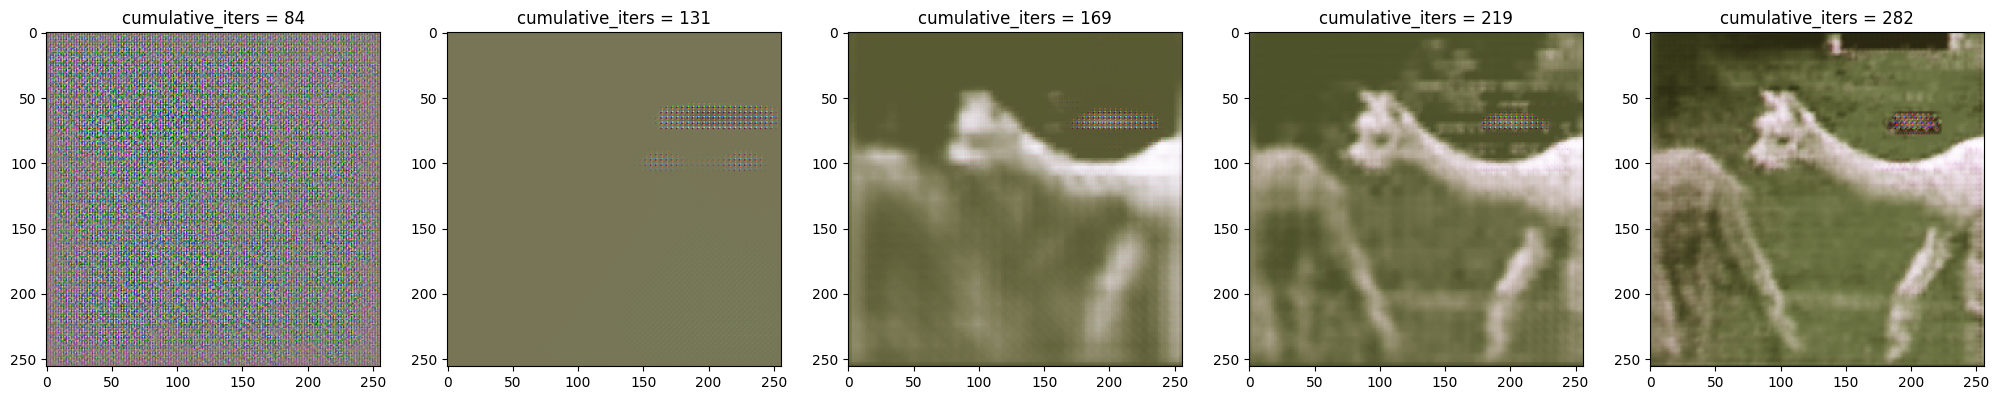

In [43]:
lr = 1e-2
hg_net = Hourglass()
hg_net.to(device)

# 創建新的優化器
optimizer = optim.Adam(hg_net.parameters(), lr=lr)

to_tensor = tv.transforms.ToTensor()
z = torch.Tensor(np.mgrid[:256, :256]).unsqueeze(0).to(device) / 256
n_iter = cumulative_iters[-1]
fig, axs = plt.subplots(1, len(noisy_image), figsize=(25, 15))
#alpha_values = {}
#diffusion = DiffusionUtils(n_iter, beta_min, beta_max, scheduler=scheduler)
#alpha_values[scheduler] = diffusion.alphas
withoutnoise_psnr_values = []
withoutnoise_ssim_values = []
withoutnoise_losses = []
cul_iter=0
for t in range(len(noisy_image)):
  temp_y = hg_net(z)
  for i in range(iters[t]):
      optimizer.zero_grad()

      y = hg_net(z)
      loss = mse(noisy_image[-1], y)
      psnr_value = calculate_psnr(sample_img, y)
      withoutnoise_psnr_values.append(psnr_value)
      ssim_value = calculate_ssim(sample_img, y)
      withoutnoise_ssim_values.append(ssim_value)
      withoutnoise_losses.append(loss.item())
      loss.backward()
      optimizer.step()
  temp_y = temp_y[0].cpu().detach().permute(1,2,0)*255
  temp_y = np.array(temp_y, np.uint8)
  cul_iter += iters[t]
  print('Iteration: {} Loss: {:.07f}'.format(cul_iter, withnoise_losses[-1]))
  axs[t].imshow(temp_y)
  axs[t].set_title(f'cumulative_iters = {cul_iter}')
plt.show()
print('\n')

with torch.no_grad():
  out = hg_net(z)
  out = out[0].cpu().detach().permute(1,2,0)*255
  out = np.array(out, np.uint8)
plt.imsave('withoutnoise_final2.jpg', out)


# 刪除模型並釋放內存
del hg_net
torch.cuda.empty_cache()
# 刪除優化器
del optimizer

In [44]:

cumulative_iters[-1]

282

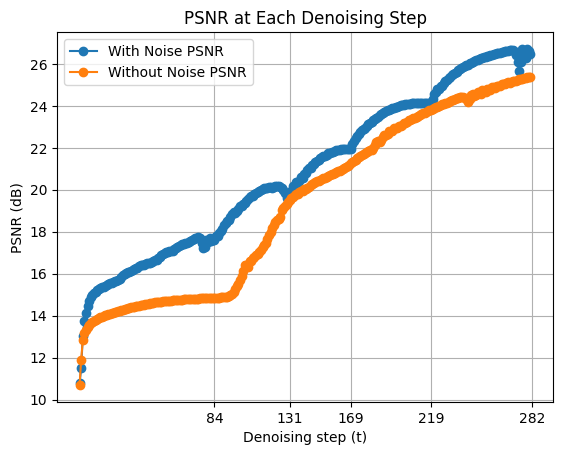

In [45]:
# 繪製 PSNR 折線圖

plt.figure()
plt.plot(range(cumulative_iters[-1]), withnoise_psnr_values, marker='o', label='With Noise PSNR')
plt.plot(range(cumulative_iters[-1]), withoutnoise_psnr_values, marker='o', label='Without Noise PSNR')
plt.xlabel('Denoising step (t)')
plt.ylabel('PSNR (dB)')
plt.title('PSNR at Each Denoising Step')
plt.grid(True)
plt.legend()
plt.xticks(cumulative_iters)
plt.show()

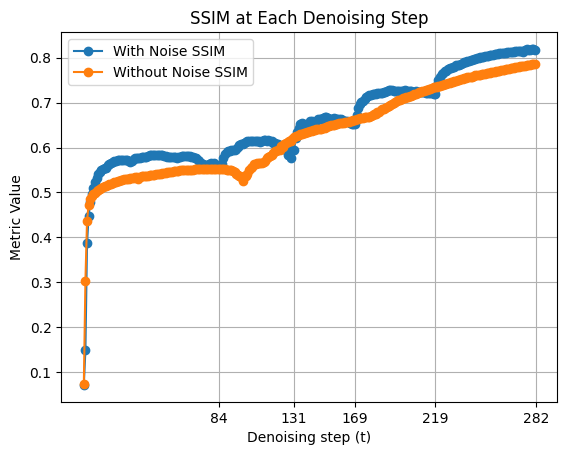

In [46]:
# 繪製 SSIM 折線圖
plt.figure()
plt.plot(range(n_iter), withnoise_ssim_values, marker='o', label='With Noise SSIM')
plt.plot(range(n_iter), withoutnoise_ssim_values, marker='o', label='Without Noise SSIM')
plt.xlabel('Denoising step (t)')
plt.ylabel('Metric Value')
plt.title('SSIM at Each Denoising Step')
plt.legend()
plt.grid(True)
plt.xticks(cumulative_iters)

plt.show()

In [47]:


#plt.imsave('start.jpg', x[0].cpu().detach().permute(1,2,0).numpy())

#imageio.mimsave('progress.gif', images)

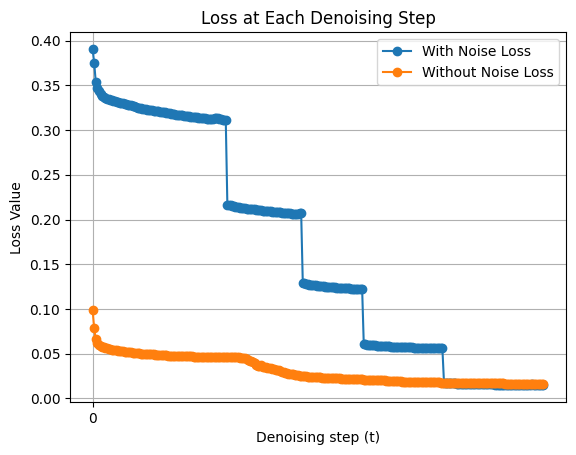

In [48]:
# 繪製 SSIM 折線圖
plt.figure()
plt.plot(range(n_iter), withnoise_losses, marker='o', label='With Noise Loss')
plt.plot(range(n_iter), withoutnoise_losses, marker='o', label='Without Noise Loss')
plt.xlabel('Denoising step (t)')
plt.ylabel('Loss Value')
plt.title('Loss at Each Denoising Step')
plt.legend()
plt.grid(True)
plt.xticks(range(0, n_iter + 1, iter))
plt.show()